In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
from plotly_resampler import FigureResampler
import plotly.io as pio
pio.renderers
pio.renderers.default = "notebook_connected"

/opt/homebrew/Caskroom/miniforge/base/envs/cs302/lib/python3.10/site-packages/plotly_resampler/aggregation/aggregators.py:24: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
def create_sun(size, clr, dist=0, opacity=1): 
    
    # Set up 100 points. First, do angles
    theta = np.linspace(0,2*np.pi,100)
    phi = np.linspace(0,np.pi,100)
    
    # Set up coordinates for points on the sphere
    x0 = dist + size * np.outer(np.cos(theta),np.sin(phi))
    y0 = size * np.outer(np.sin(theta),np.sin(phi))
    z0 = size * np.outer(np.ones(100),np.cos(phi))
    
    # Set up trace
    trace = go.Surface(x=x0, y=y0, z=z0, colorscale=[[0,clr], [1,clr]], opacity=opacity)
    trace.update(showscale=False)

    return trace

def create_photon(x, y, z, clr='white', wdth=2):
    trace = go.Scatter3d(x=x, y=y, z=z, line=dict(color=clr, width=wdth), marker=dict(size=0.1))

    return trace

In [3]:
# Numbers assume hydrogen atoms
# sources:
# https://observatory.astro.utah.edu/sun.html
# http://solar-center.stanford.edu/vitalstats.html
# https://physicsanduniverse.com/random-walk-photon/
# https://www.compadre.org/osp/items/detail.cfm?ID=11349

## SOME HELPFUL FUNCTIONS ##
def kgm3_to_cmg3(val):
  # convert unit from kg/m^3 to cm/g^3
  return val / 1000

def mfp(density, opacity):
  # calculate mean free path with given hydrogen atom density values and opacity
  return 1.0 / (density * opacity)

def distance_from_center(l, N):
  # distance from starting point at current step

  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  # TODO: this only gives average expected distance, not actual distance of mapped photon
  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  return l * np.sqrt(N)

def calc_escape_time(R, l):
  # time it takes for photon to reach sun's surface in seconds
  return np.square(R) / (mfp * C)

def seconds_to_years(secs):
  # convert seconds to years
  return int(secs/31_556_952)

def distance(coordinates):
  x, y, z = coordinates
  return np.sqrt(x**2 + y**2 + z**2)

def time_to_run():
  rad = (R * SCALE) / 1000
  time_in_secs = rad * 0.014275893554076538
  return time_in_secs


### CONSTANTS ###

# DENSITY VALUES TO BE USED IN TESTING
sun_layer_densities = {'core': 1.622e5,
                       'radiative': [20_000, 200],
                       'convective': 200} # values are approximate - kg/m^3
linearly_decreasing_density = np.linspace(1.622e5, 200, num=int(7.0e8))
sun_avg_density = 1408.0 # average density of the sun - kg/m^3

C = 3.0e8 # speed of light m/s
opacity = 3.0 # opacity m^2/kg
l = mfp(sun_avg_density, opacity) # mean free path
R = 7.0e8 # sun's radius in meters
SCALE = 1/10_000_000 # scale the sun so that the simulation actually runs
N = 0 # current step


time_to_run()

0.0009993125487853577

In [4]:
class Photon:
    """
    a single photon in space
    """

    # def __init__(self, total_iterations, sun_radius) -> None:
    def __init__(self) -> None:
        # create 
        # gen random location to start
        # TODO: Change to random location instead of 0

        self.history = [[0, 0, 0]]

    def next_distance(self, function):
        """
        calculate the next distance for the photon to travel before an interaction

        Parameters
        ----------
        self: the photon class
        function: the modeling function that calculates the distance
        """
        res = function()

        return res

    def next_loc(self, distance):
        """
        get the next photon location

        Parameters
        ----------
        self: self
        distance: float, representing the radius of the sphere for possible next location
        """
        # coord system, need a z and a phi

        # this is the axis from south to north pole, use the distance radius for this
        z = np.random.uniform(distance * -1, distance)

        # phi is the angle, which is the "longitude"
        phi = np.random.uniform(0, 1) * 2 * np.pi

        # calculate the theta
        theta = phi * 2 * np.pi

        # gen points
        x = distance * np.cos(theta) * np.cos(phi)
        y = distance * np.cos(theta) * np.sin(phi)
        
        # update tracking location
        # take previous iteration, append values
        final_x = self.history[-1][0] + x
        final_y = self.history[-1][1] + y
        final_z = self.history[-1][2] + z

        self.history.append([final_x, final_y, final_z])


## Model # 1

Average density model.

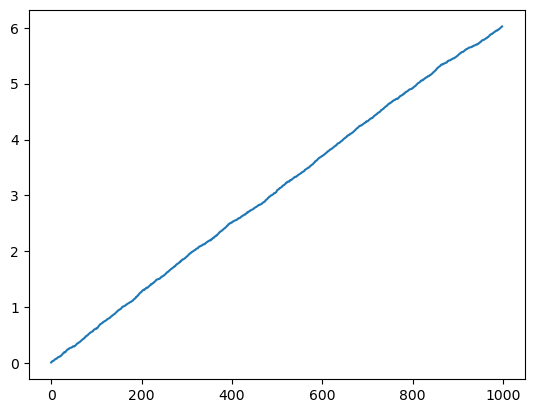

In [5]:
l = mfp(sun_avg_density, opacity) # mean free path using average density and opacity
p = Photon()
N = 0
dist = []
while distance(p.history[-1]) < R*SCALE:
  N += 1
  if N % 1000 == 0:
    if N % 1000000 == 0:
      plt.plot(dist)
      plt.show()
      break
    dist.append(distance(p.history[-1]))
    # print(f'N={N}: {distance(p.history[-1])}')
  p.next_loc(l)

photon_track = np.array(p.history)

In [6]:
fig = FigureResampler(go.Figure())

sun = create_sun(R * SCALE, '#ffff00', 0, 0.2) # Sun

# for photons, we will use scatter3d
photon = create_photon(photon_track[:,0], photon_track[:,1], photon_track[:,2], clr='red')

# fig = go.Figure(data = [sun, photon])
fig.add_trace(sun)
fig.add_trace(photon)

fig.show_dash(mode='inline')